# PRS-CSx Tutorial

## Part 1. Running PRS-CSx

### Inputs:
1. Reference panel for EAS population: ldblk_1kg_eas.tar.gz
2. Reference panel for EUR population: ldblk_1kg_eur.tar.gz
3. SNP information: snpinfo_mult_1kg_hm3
4. EAS population summary statistics: EAS_sumstats.txt
5. EUR population summary statistics: EUR_sumstats.txt

### Outputs
1. EAS PRS (contains population-specific posterior SNP effect size estimates for each individual): test_EAS_pst_eff_a1_b0.5_phi1e-02_chr22.txt
2. EUR PRS (contains population-specific posterior SNP effect size estimates for each individual): test_EUR_pst_eff_a1_b0.5_phi1e-02_chr22.txt

### Check if bash and curl are available:
If you run into an error, please install them and then run the following

In [6]:
!bash --version
!which bash
!curl --version

GNU bash, version 3.2.57(1)-release (arm64-apple-darwin23)
Copyright (C) 2007 Free Software Foundation, Inc.
/bin/bash
curl 8.9.1 (arm64-apple-darwin20.0.0) libcurl/8.9.1 OpenSSL/3.0.15 zlib/1.2.13 libssh2/1.11.0 nghttp2/1.57.0
Release-Date: 2024-07-31
Protocols: dict file ftp ftps gopher gophers http https imap imaps ipfs ipns mqtt pop3 pop3s rtsp scp sftp smb smbs smtp smtps telnet tftp
Features: alt-svc AsynchDNS GSS-API HSTS HTTP2 HTTPS-proxy IPv6 Kerberos Largefile libz NTLM SPNEGO SSL threadsafe TLS-SRP UnixSockets


### Import Python packages:

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
from IPython.display import Markdown

### Set the working directory

In [10]:
# Set the working directory as the parent folder of where the script is located and save it as a variable named "cwd"
cwd = os.path.dirname(os.getcwd())
os.chdir(cwd)

# Inspect the current working directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/aliceyan/Documents/GitHub/prs-csx-workshop-tutorial-updated-11262024


### Inspect the bash script to run PRS-CSx

In [12]:
# Absolute path to the bash script
bash_script_path = os.path.join(cwd, "scripts/run_prscsx.sh")
print(f"Bash script path: {bash_script_path}")

# Read the script content
with open(bash_script_path, "r") as file:
    bash_script_content = file.read()

# Display the script as preformatted Markdown
Markdown(f"```bash\n{bash_script_content}\n```")

Bash script path: /Users/aliceyan/Documents/GitHub/prs-csx-workshop-tutorial-updated-11262024/scripts/run_prscsx.sh


```bash
#!/bin/bash

## Setting Up PRS-CSx 

# 0. Set the working directory as the parent directory of which the script is located.
echo "Current working directory: $(realpath ./)"

# 1. Clone the PRS-CSx repository using the following git command:
git clone https://github.com/getian107/PRScsx.git

# 2. Create a sub-folder named `ref`. Download the LD reference panels to `ref` and extract files:
# For regions that don't have access to Dropbox, reference panels can be downloaded from the [alternative download site](https://personal.broadinstitute.org/hhuang/public/PRS-CSx/Reference/).
mkdir -p ref
echo "Downloading files..."
EAS_REF_URL="https://www.dropbox.com/s/7ek4lwwf2b7f749/ldblk_1kg_eas.tar.gz?dl=1"
EUR_REF_URL="https://www.dropbox.com/s/mt6var0z96vb6fv/ldblk_1kg_eur.tar.gz?e=1&dl=0"
EAS_REF_DIR="./inputs/ref/ldblk_1kg_eas.tar.gz"
EUR_REF_DIR="./inputs/ref/ldblk_1kg_eur.tar.gz"
curl -L -o "$EAS_REF_DIR" "$EAS_REF_URL"
curl -L -o "$EUR_REF_DIR" "$EUR_REF_URL"
echo "Download completed: 1)EAS ref: $(realpath "$EAS_REF_DIR"), 2) EUR ref: $(realpath "$EUR_REF_DIR")"
echo "Extracting files..."
tar -zxvf "$EAS_REF_DIR" -C "./inputs/ref"
tar -zxvf "$EUR_REF_DIR" -C "./inputs/ref"
echo "Extraction completed."

# 3. Download the SNP information file and put it in the same folder containing the reference panels:
SNP_INFO_URL="https://www.dropbox.com/s/rhi806sstvppzzz/snpinfo_mult_1kg_hm3?dl=0"
SNP_INFO_DIR="./inputs/ref/snpinfo_mult_1kg_hm3"
curl -L -o "$SNP_INFO_DIR" "$SNP_INFO_URL"

# 4. PRScsx requires Python packages `scipy` and `h5py` installed:
# Function to check and install a Python package
check_and_install_package() {
    PACKAGE=$1
    if python -c "import $PACKAGE" &> /dev/null; then
        echo "$PACKAGE is already installed."
    else
        echo "$PACKAGE is not installed. Installing..."
        pip install $PACKAGE
        if [ $? -eq 0 ]; then
            echo "$PACKAGE installed successfully."
        else
            echo "Failed to install $PACKAGE. Please check your Python and pip setup."
            exit 1
        fi
    fi
}

# Ensure pip is available
if ! command -v pip &> /dev/null; then
    echo "pip is not installed. Please install pip and rerun this script."
    exit 1
fi

# Check and install scipy and h5py
check_and_install_package "scipy"
check_and_install_package "h5py"

# 5. Once Python and its dependencies have been installed, running the following will print a list of command-line options:
echo "Printing PRScsx command options..."
./PRScsx/PRScsx.py --help 

## Using PRS-CSx with Test Data
# The test data contains EUR and EAS GWAS summary statistics and a bim file for 1,000 SNPs on chromosome 22.
# 1. Create a directory to store output:
mkdir -p outputs
OUTPUT_FOLDER_DIR=$(realpath "./outputs")
    
# 2. Run PRS-CSx:
echo "Running PRS-CSx on test data..."
python ./PRScsx/PRScsx.py \
    --ref_dir=./inputs/ref \
    --bim_prefix=./PRScsx/test_data/test \
    --sst_file=./PRScsx/test_data/EUR_sumstats.txt,./PRScsx/test_data/EAS_sumstats.txt \
    --n_gwas=200000,100000 \
    --pop=EUR,EAS \
    --chrom=22 \
    --phi=1e-2 \
    --out_dir=./outputs \
    --out_name=test
echo "PRS-CSx finished running: $OUTPUT_FOLDER_DIR"

```

### Explanation of the input of PRS-CSx
`ref_dir` --> PATH_TO_REFERENCE (required): Full path to the directory that contains the SNP information file and LD reference panels. If the 1000 Genomes reference is used, the folder would contain the SNP information file snpinfo_mult_1kg_hm3 and one or more of the LD reference files: ldblk_1kg_afr, ldblk_1kg_amr, ldblk_1kg_eas, ldblk_1kg_eur, ldblk_1kg_sas; if the UK Biobank reference is used, the folder would contain the SNP information file snpinfo_mult_ukbb_hm3 and one or more of the LD reference files: ldblk_ukbb_afr, ldblk_ukbb_amr, ldblk_ukbb_eas, ldblk_ukbb_eur, ldblk_ukbb_sas. (In our script, we used the 1000 Genomes reference.)

`bim_prefix` --> VALIDATION_BIM_PREFIX (required): Full path and the prefix of the bim file for the target (validation/testing) dataset. This file is used to provide a list of SNPs that are available in the target dataset.

`sst_file` --> SUM_STATS_FILE (required): Full path and the file name of the GWAS summary statistics. Multiple GWAS summary statistics files are allowed and should be separated by comma. The summary statistics file must include either BETA/OR + SE or BETA/OR + P. The formats are specified on the Github.

`n_gwas` --> GWAS_SAMPLE_SIZE (required): Sample sizes of the GWAS, in the same order of the GWAS summary statistics files, separated by comma.

`pop` --> POPULATION (required): Population of the GWAS sample, in the same order of the GWAS summary statistics files, separated by comma. For both the 1000 Genomes reference and the UK Biobank reference, AFR, AMR, EAS, EUR and SAS are allowed.

`chrom` --> CHROM (optional): The chromosome on which the model is fitted, separated by comma, e.g., --chrom=1,3,5. Parallel computation for the 22 autosomes is recommended. Default is iterating through 22 autosomes (can be time-consuming).

`phi` --> PARAM_PHI (optional): Global shrinkage parameter phi. If phi is not specified, it will be learnt from the data using a fully Bayesian approach. This usually works well for polygenic traits with very large GWAS sample sizes (hundreds of thousands of subjects). For GWAS with limited sample sizes (including most of the current disease GWAS), fixing phi to 1e-2 (for highly polygenic traits) or 1e-4 (for less polygenic traits), or doing a small-scale grid search (e.g., phi=1e-6, 1e-4, 1e-2, 1) to find the optimal phi value in the validation dataset often improves perdictive performance.

`out_dir` --> OUTPUT_DIR (required): Output directory of the posterior effect size estimates.

`out_name` --> OUTPUT_FILE_PREFIX (required): Output filename prefix of the posterior effect size estimates.

More optional flags are explained in the Github.

Reference: https://github.com/getian107/PRScsx

### Run the bash script to run PRS-CSx

In [15]:
print(bash_script_path)
with open(bash_script_path, "w") as file:
    file.write(bash_script_content)

# Make the script executable
!chmod +x ./scripts/run_prscsx.sh

# Run the script
!./scripts/run_prscsx.sh

/Users/aliceyan/Documents/GitHub/prs-csx-workshop-tutorial-updated-11262024/scripts/run_prscsx.sh
Current working directory: /Users/aliceyan/Documents/GitHub/prs-csx-workshop-tutorial-updated-11262024
fatal: destination path 'PRScsx' already exists and is not an empty directory.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   137  100   137    0     0    584      0 --:--:-- --:--:-- --:--:--   585
100    17  100    17    0     0     19      0 --:--:-- --:--:-- --:--:--    19
100   496    0   496    0     0    305      0 --:--:--  0:00:01 --:--:--   734
100 4131M  100 4131M    0     0  35.7M      0  0:01:55  0:01:55 --:--:-- 39.6M:58  0:01:26  0:00:32 36.3M 0  0:01:58  0:01:28  0:00:30 36.3M 0:01:57  0:01:35  0:00:22 37.6M54  0:00:01 39.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total 

### Explanation of the output of PRS-CSx
*For each input GWAS, PRS-CSx writes `posterior SNP effect size estimates for each chromosome` to the user-specified directory. The output file contains `chromosome, rs ID, base position, A1, A2 and posterior effect size estimate for each SNP`.*

*An individual-level polygenic score can be produced by concatenating output files from all chromosomes and then using PLINK's --score command (https://www.cog-genomics.org/plink/1.9/score). If polygenic scores are generated by chromosome, use the 'sum' modifier so that they can be combined into a genome-wide score.* In our tutorial, we are going to demonstrate this calculation process. We will multiply the posterior SNP effect sizes for chromosome 22 by the individual's genotype matrix to compute the PRS.

### How to use PRS-CSx?
*Given a global shrinkage parameter, the first approach calculates `one polygenic score for each discovery population` using `population-specific posterior SNP effect size estimates` and learns a `linear combination of the polygenic scores` that most accurately predicts the trait in the validation dataset. The optimal global shrinkage parameter and linear combination weights are then taken to an independent dataset, where the predictive performance of the final PRS can be assessed.* The second approach is explained in detail in the Github.

Reference: https://github.com/getian107/PRScsx

We will domonstrate the usage of PRS-CSx in the following part.

## Part 2. Using the results of PRS-CSx

### Process PRS-CSx results to extract the weights for variants that exist in both populations

In [19]:
# Cut the PRS-CSx output files to keep only the rsid and the effect size
!awk '{print $2 "\t" $6}' ./outputs/test_EAS_pst_eff_a1_b0.5_phi1e-02_chr22.txt > ./outputs/EAS_prscsx_output_cut
!awk '{print $2 "\t" $6}' ./outputs/test_EUR_pst_eff_a1_b0.5_phi1e-02_chr22.txt > ./outputs/EUR_prscsx_output_cut

In [20]:
# Extract rsid column and sort the files
!cut -f1 "./outputs/EAS_prscsx_output_cut" | sort > ./outputs/EAS_prscsx_output_cut_sorted
!cut -f1 "./outputs/EUR_prscsx_output_cut" | sort > ./outputs/EUR_prscsx_output_cut_sorted

# Find common items between the two sorted files
!comm -12 ./outputs/EAS_prscsx_output_cut_sorted ./outputs/EUR_prscsx_output_cut_sorted > "./outputs/overlap_risk_variants.txt"

# Clean up temporary files
!rm ./outputs/EAS_prscsx_output_cut_sorted ./outputs/EUR_prscsx_output_cut_sorted

In [21]:
# Read in the overlapping variants file
with open("./outputs/overlap_risk_variants.txt", "r") as file:
    overlap_var_list = [line.strip() for line in file]  # Removes newline characters

# Obtain W_eas
pd.set_option('display.float_format', lambda x: '%.10f' % x)
EAS_var_w = pd.read_csv("./outputs/EAS_prscsx_output_cut", sep = '\t', header = None, float_precision = 'high')
W_eas = EAS_var_w[EAS_var_w[0].isin(overlap_var_list)][[1]]
W_eas = W_eas.values

# 0btain W_eur
EUR_var_w = pd.read_csv("./outputs/EUR_prscsx_output_cut", sep = '\t', header = None, float_precision = 'high')
W_eur = EUR_var_w[EUR_var_w[0].isin(overlap_var_list)][[1]]
W_eur = W_eur.values

### Prepare the genotype matrix X and phenotype matrix y in validation and testing datasets

In [23]:
# Read in the file that has genotype and phenotype for each individual
geno_pheno_matrix_path = cwd + "/outputs/genotype_phenotype_matrix"
geno_pheno_matrix = np.loadtxt(geno_pheno_matrix_path)

# The file is prepared such that it has 504 rows (individuals) x 902 columns (variants + effect sizes); 
# entries: first 901 columns: allele count for each variant; last column = simulated phenotype value for the individual
print(geno_pheno_matrix)
print(geno_pheno_matrix.shape)

[[2.         0.         0.         ... 0.         1.         0.02797135]
 [2.         0.         1.         ... 0.         0.         0.06679839]
 [1.         0.         2.         ... 1.         2.         0.05880101]
 ...
 [0.         0.         1.         ... 0.         1.         0.05491714]
 [1.         0.         2.         ... 0.         0.         0.05136679]
 [1.         0.         2.         ... 0.         1.         0.07522301]]
(504, 902)


In [24]:
# Separate genotype and phenotype information
geno = geno_pheno_matrix[:, :-1] # extract all the rows, and all the columns except the last one
phen = geno_pheno_matrix[:, -1] # extract all the rows, and only the last column

# print(geno.shape)# geno is a 2D array (matrix) with 504 rows and 901 columns
# print(geno) # output: (504, 901)

# print(phen.shape) # phen is a 1D array with 504 elements
# print(phen) # output: (504,)

### Split Validation and Test Datasets

In [26]:
np.random.seed(154) # set a random seed for reproducibility
vali_proportion = 0.4 # specify the proportion of data to be used for validation
vali_size = int(geno.shape[0] * vali_proportion) # calculate the number of samples based on the proportion

vali_indices = np.random.choice(geno.shape[0], vali_size, replace = False) 
# randomly select a unique set of indices for the validation dataset
# np.random.choice: method to generate a random sample from a given 1D array or integer range
# geno.shape[0]: 504 --> range to sample from (rows of geno df = total number of individuals/samples)
# vali_size: 202 --> how many samples to pick from the range
# replace = False --> once the index is chosen, it can't be chosen again

test_indices = np.setdiff1d(np.arange(geno.shape[0]), vali_indices)
# np.setdiff1d(A, B): function that returns the sorted, unique values in array A that are not in array B
# A = np.arange(geno.shape[0]): an array of consecutive int ranging from 0 to geno.shape[0]-1
# B = vali_indices: an array that contains the indices selected for validation

# Extract the rows according to the indices for geno, phen, vali, and test respectively
X_vali = geno[vali_indices] 
y_vali = phen[vali_indices]

X_test = geno[test_indices]
y_test = phen[test_indices]

### Run Regression to find weight parameters a_hat and b_hat

In [28]:
# Inspect matrices' dimensions
print(X_vali.shape)
print(y_vali.shape)
print(W_eas.shape)
print(W_eur.shape)

(201, 901)
(201,)
(901, 1)
(901, 1)


### Prepare the model input

In [30]:
XWeas_vali = X_vali @ W_eas # based on the equation, calculate the weighted input data for the EAS population
XWeur_vali = X_vali @ W_eur
XW_vali = np.hstack((XWeas_vali, XWeur_vali)) 
# horizontally stack the weighted inputs for both population for model input

# In essence, this block of code takes the validation data, 
# multiplies it by population-specific weight matrices, 
# and then concatenates the results side by side to form a combined input for the model.

### Fit the model

In [32]:
model = LinearRegression(fit_intercept = False).fit(XW_vali, y_vali) 

# we usually don’t include intercept in the PRS calculation. 
# As a result the PRS calculated in this manner only reflects the relative risk, not the absolute risk.

### Obtain the regression parameters

In [34]:
a_hat = model.coef_[0]
b_hat = model.coef_[1]
print(f"{a_hat =}")
print(f"{b_hat =}")

a_hat =0.874241385180658
b_hat =0.14712367724718467


### Predict Phenotype on Validation and Test Datasets

In [36]:
# Make predictions on validation data
y_hat_vali = a_hat * XWeas_vali + b_hat * XWeur_vali
print(y_hat_vali.shape)
y_hat_vali = y_hat_vali.flatten() #flatten(): method that flatten a 2D matrix into a 1D array
print(y_hat_vali.shape)

(201, 1)
(201,)


In [37]:
# Make the prediction on test data
XWeas_test = X_test @ W_eas
XWeur_test = X_test @ W_eur
y_hat = a_hat * XWeas_test + b_hat * XWeur_test
y_hat = y_hat.flatten()

## Part 3. Evalutating PRS-CSx

### Plot True values against Predicted Values

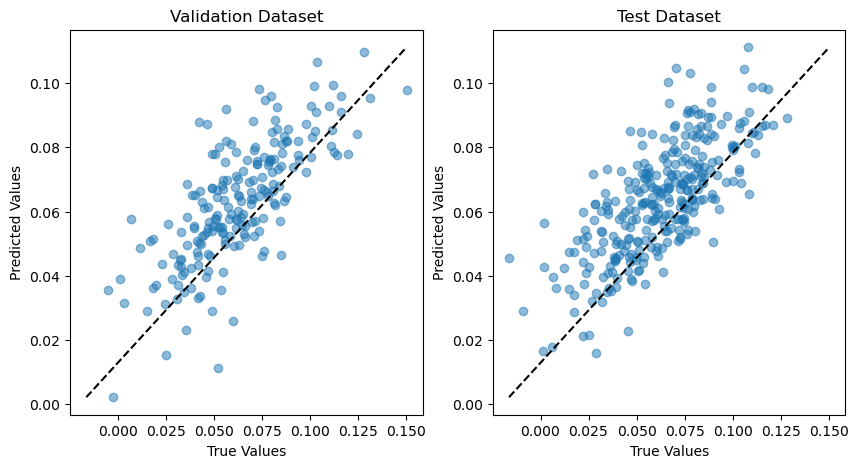

In [40]:
plt.figure(figsize = (10, 5)) # create a blank canvas 10 in. wide x 5 inch. tall

# Compute global minimum and maximum for x and y axes for setting the x & y ranges
min_true = min(min(y_vali), min(y_test))
max_true = max(max(y_vali), max(y_test))
min_pred = min(min(y_hat_vali), min(y_hat))
max_pred = max(max(y_hat_vali), max(y_hat))

# For the validation cohort
plt.subplot(1, 2, 1) # (# rows, # columns, index of this plot)
plt.scatter(y_vali, y_hat_vali, alpha = 0.5) # alpha sets the transparency of the dot markers
plt.title('Validation Dataset')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min_true, max_true], [min_pred, max_pred], 'k', linestyle='dashed') 
# draw a line that shows perfect correlation between true and predicted values

# For the test cohort
plt.subplot(1, 2, 2) 
plt.scatter(y_test, y_hat, alpha = 0.5)
plt.title('Test Dataset')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min_true, max_true], [min_pred, max_pred], 'k', linestyle='dashed')

# Save the figure & inspect it!
plt.savefig(cwd + '/outputs/true_against_pred.png') 

### Evaluate Using Deviance-based R<sup>2</sup>

In [42]:
# Calculate the deviance based on the y_hat for the test data 
# (= residual deviance = total squared difference between the true output values and the predicted output values)
deviance = mean_squared_error(y_test, y_hat, squared = True) * len(y_test)
# mean_squared_error(): calculates the mean squared error (MSE) between true and predicted values, 
# which is the average squared differences between true and predicted values

# multiplying it with len(y_test) gives the total squared difference
print(f"{deviance = }")

deviance = 0.0966314370800322


/Users/aliceyan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
# Calculate null deviance = total squared difference between the true output values and their mean
# *Null model predicts every instance with the mean of the output variable
y_test_mean = np.mean(y_test)
deviance_null = np.sum((y_test - y_test_mean) ** 2) 
print(f"{deviance_null = }")

deviance_null = 0.20128019254673396


In [44]:
# Calculate deviance-based R2
R2 = 1 - (deviance / deviance_null)
print(f"{R2 = }")

R2 = 0.5199158155733781
